# 동아대 교육 2일차 2강

* 강의명 : 파이썬으로 배우는 생물 정보학 기초
* 강사 : DSC 박주희 (jheepark@insilicogen.com)

본 노트북에서는 RNA-seq CPM 데이터셋을 활용하여 전사체 데이터 분석을 수행합니다.

1.   외부 라이브러리 설치
2.   데이터 셋 확인
3.   데이터 셋 필터링 및 전처리
4.   PCA 분석
5.   DEG 분석 (Heatmap,
Volcano plot)
6.   결과 검증 (Box plot)

## (1) 외부 라이브러리 설치

외부 라이브러리는 파이썬 코드 내에서는 설치가 불가능함.

하지만 Colab, Jupyter 에서는 magic keyword [ ! ] 를 활용해서 shell 명령어를 수행할 수 있음.

* `pip list`
* `pip install`
* `import`

### pip list

Colab에서 제공하는 기본 외부 라이브러리 확인
(필요 외부 라이브러리 리스트 확인)

In [ ]:
!pip list | grep -i -E "pandas|numpy|seaborn|matplotlib|scipy|scanpy|pydeseq2"

### pip install

설치가 필요한 외부라이브러리 설치
* scanpy, pydeseq2

In [ ]:
# Colab의 기본 설정으로 설치되지 않은 라이브러리 설치
!pip install scanpy
!pip install pydeseq2

### import

필요한 라이브러리 import

In [ ]:
# 파이썬 내장 라이브러리
import os
import pickle

# 파이썬 외장 라이브러리
## 데이터 핸들링
import pandas as pd
import numpy as np

## 데이터 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

## 통계 분석
from scipy.stats import ttest_ind

## RNA-seq 분석
import scanpy as sc
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

## (2) 데이터 로드 및 읽기

분석에 활용할 데이터 셋은 GEO accession number: `GSE111016` 데이터를 전처리한 데이터임.

    * Platform: Illumina HiSeq 2500 (Homo sapiens)
    * 샘플 수 : 40 샘플 (control 20명, sarcopenia 20명)
    * 데이터셋 링크: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE111016  
    * 전처리 과정 : Gene symbol mapping,


* 데이터 업로드
* 데이터 read 및 확인
   - meta data - Condition 분포 확인
   - count data - 원시 카운트 분포 확인


### 데이터 업로드

파일 항목에 전달 파일 업로드

* GSE111016_counts_matrix.csv (cpm matrix)
* GSE111016_metadata_matrix.csv (metadata matrix)

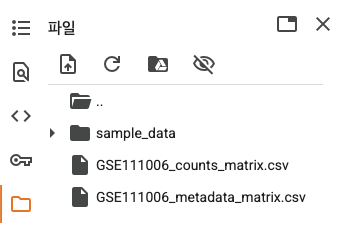

### 데이터 read 및 확인

CPM matrix(행=유전자, 열=샘플)와 메타데이터(변수: Condition) 데이터를 읽어 변수로 저장합니다.  `shape` 와 `head()` 명령어로 각 행렬을 확인합니다.

In [ ]:
# 현 폴더
base_dir = './'

In [ ]:
# raw 읽어오기
metadata = pd.read_csv(os.path.join(base_dir, 'GSE111016_metadata_matrix.csv'), sep='\t', index_col=[0])
counts = pd.read_csv(os.path.join(base_dir, 'GSE111016_counts_matrix.csv'), sep='\t', index_col=[0], low_memory=False)

In [ ]:
print(metadata.shape)
metadata.head()

OS, OH 구분별 시각화 - 각 구분별 20샘플씩 분포함

In [ ]:
# Condition 변수 분포
metadata.groupby('Condition').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
print(counts.shape)
counts.head()

Sample 1개의 expression histogram - 데이터가 0에 가까운 skewed한 분포를 띔.

In [ ]:
# counts matrix에서 첫 번째 샘플 선택
sample_counts = counts.iloc[:, 0]

# 히스토그램과 KDE 플롯 그리기
plt.figure(figsize=(10, 6))
sns.histplot(sample_counts, bins=20)
plt.title("Distribution of Counts for Sample 1")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.ticklabel_format(style='plain', axis='x') # x축 레이블 형식을 일반 숫자로 설정
plt.show()

## (3) 데이터 필터링 및 전처리

아래 내용을 샘플별 boxplot으로 확인합니다.
* 원본 데이터 발현량
* 저발현 유전자 제거 후 발현량
* log transform 후 발현량

### 원본 데이터 발현량

In [ ]:
fig = plt.figure(figsize=(14, 5))
counts.boxplot(rot=60)
plt.title("raw counts by sample ")
plt.ylabel("raw count")
plt.xlabel("Sample")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

### 저발현 유전자 제거 후 발현량
논문상 필터링 기준 - 평균 발현량이 20보다 큰 유전자만 필터링

In [ ]:
# 논문 상 필터링 기준
print(f'필터링 전 테이블: {counts.shape}')
counts = counts[counts.mean(axis=1)>20]
print(f'논문기반 필터링 후 테이블: {counts.shape}')

저발현 유전자가 제거된 것으로, 전체 분포는 유사함.

In [ ]:
fig = plt.figure(figsize=(14, 5))
counts.boxplot(rot=60)
plt.title("filtered counts by sample ")
plt.ylabel("raw count")
plt.xlabel("Sample")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


### log transform 후 발현량

정규성을 띈 분포로 변환됨. (시각화 시 수행하기 때문에 분포만 확인)

In [ ]:
log_counts = np.log2(counts + 1)

In [ ]:
fig = plt.figure(figsize=(14, 5))
log_counts.boxplot(rot=60)
plt.title("log transform counts by sample ")
plt.ylabel("raw count")
plt.xlabel("Sample")
plt.tight_layout()
plt.show()

## (4) 클러스터링 확인

### PCA

배치나, outlier 존재 파악, 클러스터링 경향 확인을 위해 수행

In [ ]:
counts = counts.T

In [ ]:
dds = DeseqDataSet(counts=counts,
                       metadata=metadata,
                       design="Condition",
                       refit_cooks=True)

print(dds.obs.Condition.unique())

OH와 OS 샘플이 완전히 분리되지 않고 섞여 있어 별도의 배치 보정은 필요하지 않음.

In [ ]:
sc.tl.pca(dds)
sc.pl.pca(dds, color='Condition', size=200)

## (5) DEG 분석

In [ ]:
def my_deseq(metadata, counts, name):
    # 1. Build DeseqDataSet
    dds = DeseqDataSet(counts=counts,
                       metadata=metadata,
                       design_factors="Condition",
                       refit_cooks=True)

    # 2. Run DEseq2
    dds.deseq2()

    dds_df = pd.DataFrame(
    dds.X,
    index=dds.obs_names,   # 샘플 이름
    columns=dds.var_names  # 유전자 이름
    )

    # 3. Deseq2Stat # 1:'os', 2:'oh'
    group1 = dds.obs.Condition.unique()[1] # 1: 'os'
    group2 = dds.obs.Condition.unique()[0] # 0: 'oh'
    print(f"comparison between {group1} and {group2}")

    stat_res = DeseqStats(dds, contrast=('Condition', group1, group2))
    stat_res.summary()
    res = stat_res.results_df

    # 4. Save dds and res as pickle and csv, respectively
    with open(os.path.join(base_dir, f"results_{name}_dds.pkl"), 'wb') as f:
        pickle.dump(dds, f)
    res.to_csv(os.path.join(base_dir, f"results_{name}.csv"))

    return res, dds

In [ ]:
osoh, osoh_dds = my_deseq(metadata, counts, 'GSE111016_osoh_filtered_refit')

열 : gene, baseMean/avgCPM, log2FC, log2FC SE, stat, p-value, padj(FDR)

In [ ]:
osoh.head()

In [ ]:
osoh_dds.obs.head()

유의한 유전자 기준 : p_value < 0.05 & |log2FC| ≥ 1

In [ ]:
# 설정
num = 0
res = osoh
dds = osoh_dds

dic = {'OH vs OS' : ['OH','OS']}
vol = list(dic.keys())[num]
dic[vol]

lfc_cutoff = 1
pval_cutoff = 0.05

In [ ]:
# p-value의 -log10 변환
res['-log10(pvalue)'] = -np.log10(res['pvalue'])

In [ ]:
# 유의한 유전자 필터링
res_sigs = res[(res.pvalue < pval_cutoff)]
res_nosigs = res[(res.pvalue > pval_cutoff)]

# 유의하게 차이나는 유전자 필터링
res_sigs_diff = res_sigs[abs(res_sigs.log2FoldChange) > lfc_cutoff]
res_sigs_up = res_sigs[res_sigs['log2FoldChange'] > lfc_cutoff].sort_values(by='log2FoldChange', ascending=False)
res_sigs_down = res_sigs[res_sigs['log2FoldChange'] < -lfc_cutoff].sort_values(by='log2FoldChange', ascending=True)
res_sigs_middle = res_sigs[res_sigs['log2FoldChange'].between(-lfc_cutoff, lfc_cutoff)]

# 유의하지는 않지만 차이나는 유전자 필터링
res_nosigs_bottom = res_nosigs[(res_nosigs['log2FoldChange'] > lfc_cutoff) | (res_nosigs['log2FoldChange'] < -lfc_cutoff)]

In [ ]:
# 유의한 유전자 개수 추출
print(f"Up-regulated: {len(res_sigs_up)}")
print(f"Down-regulated: {len(res_sigs_down)}")
print(f"Intersected: {len(res_sigs) - len(res_sigs_diff)}")
print(f"Total: {len(res_sigs)}")

### Heatmap

샘플 간 글로벌 패턴과 군집 분리(실험군 vs 대조군)를 한눈에 확인하고 DEG 중 핵심 서브패턴(부분집단, 공조절 모듈) 확인

In [ ]:
# 히트맵에 표시할 인덱스 생성
osoh_dds.obs['Sample'] = osoh_dds.obs.index
osoh_dds.obs['Temp'] = osoh_dds.obs['Sample'].apply(lambda x:x.split(' ')[-1]).astype(int)

dds_sigs = osoh_dds[:, res_sigs_diff.index]
# dds expression table (counts는 normalized 사용)
dds_expr = pd.DataFrame(np.log1p(osoh_dds.layers['normed_counts']).T,
                             index=osoh_dds.var_names,
                             columns=osoh_dds.obs.Sample)
dds_sigs_expr = dds_expr.loc[res_sigs_diff.index]

In [ ]:
# 그룹별 및 환자별 인덱스 정렬을 위한 리스트 생성
dds.obs['Samples'] = dds.obs.index.astype(str) + '_' + dds.obs['Condition']
my_order = dds.obs.sort_values(by=['Condition', 'Temp'], ascending=[True, True])['Samples'].index.values
my_order

In [ ]:
# dds_sigs_expr 행렬 정렬
dds_sigs_expr = dds_sigs_expr.T
dds_sigs_expr = dds_sigs_expr.reindex(my_order).T

In [ ]:
# 어노테이션 설정
ann_col = dds_sigs.obs['Condition']
ann_col.index = dds_sigs.obs['Sample']

# 애노테이션 색상 설정
ann_colors = {'Group': {dic[vol][0]: '#66CDAA', dic[vol][1]: '#FFA07A'}} # 초록 66CDAA, 분 FFA07A

In [ ]:
# 히트맵 그리기
sns.clustermap(dds_sigs_expr,
               z_score=0, # standard_scale=0,
               cmap = 'RdBu_r',
               center=0,
               xticklabels=True,
               yticklabels=True,
               cbar_pos=(1, 0.1, 0.02, 0.3),
               figsize=(10,8), #(10,16),#(8, 16),
               col_colors=ann_col.map(ann_colors['Group']),
               vmin=-3,
               vmax=3,
               col_cluster=None)
plt.title(f'')
plt.show()

상단의 Condition 바(민트 vs 주황) 기준으로 좌·우가 대체로 분리되어 보임 → 군집이 Condition과 대체로 일치.

특정 유전자(예: KRT*, FLG*, DSC1 등)에서 세로 줄무늬가 뚜렷

### Volcanoplot

**효과크기(log2FC)**와 **통계적 유의성(−log10 p 또는 FDR)**를 동시에 시각화해 우선순위를 결정.

→ 우측=OH 증가, 좌측=OH 감소.

위/아래: 유의성. 가로·세로 임계선(예: |log2FC|≥1, FDR<0.05)을 넘는 점이 후보 유전자임.

In [ ]:
# 볼케이노 플롯 그리기
plt.figure(figsize=(5, 5))

# 기본 플랏
dot_size = 10
alpha_value = 0.7
sns.scatterplot(data=res, x='log2FoldChange', y='-log10(pvalue)',
                color='grey', label='_nolegend_', alpha=alpha_value, s=dot_size)
# 유의한 유전자 (빨강)
sns.scatterplot(data=res_sigs_diff, x='log2FoldChange', y='-log10(pvalue)',
                color='red', label='_nolegend_', alpha=alpha_value, s=dot_size)
sns.scatterplot(data=res_sigs_middle, x='log2FoldChange', y='-log10(pvalue)',
                color='blue', alpha=alpha_value, s=dot_size)
# 유의하지 않은 유전자 (초록)
sns.scatterplot(data=res_nosigs_bottom, x='log2FoldChange', y='-log10(pvalue)',
                color='green', alpha=alpha_value, s=dot_size)

# 그래프 라인 설정
plt.axhline(y=-np.log10(pval_cutoff), color='grey', linestyle='--')
plt.axvline(x=-lfc_cutoff, color='grey', linestyle='--')
plt.axvline(x=lfc_cutoff, color='grey', linestyle='--')

# x축 범위 조정
max_fc = max(abs(res['log2FoldChange']))
plt.xlim(-max_fc-0.5, max_fc+0.5)

# 그래프 타이틀 및 레전드
plt.title(vol)
plt.xlabel('logFC')
plt.ylabel(r'-$\log_{10}$(p-value)')

# 격자선 추가 및 간격 설정
plt.grid(True, color='lightgrey', linewidth=0.4)
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.gca().yaxis.set_major_locator(MultipleLocator(2))

# 유의한 유전자 이름 추가
res_sigs_up_genes = res_sigs_up.head()
for i in range(res_sigs_up_genes.shape[0]):
    plt.text(x=res_sigs_up_genes['log2FoldChange'].iloc[i],
             y=res_sigs_up_genes['-log10(pvalue)'].iloc[i],
             s=res_sigs_up_genes.index[i],
             fontsize=9)

res_sigs_down_genes = res_sigs_down.head()
for i in range(res_sigs_down_genes.shape[0]):
    plt.text(x=res_sigs_down_genes['log2FoldChange'].iloc[i],
             y=res_sigs_down_genes['-log10(pvalue)'].iloc[i],
             s=res_sigs_down_genes.index[i],
             fontsize=9)
plt.show()

* 우측 상단에 FLG/FLG2/DSC1/SBSN/KRT 등 -> OH 보다 OS 에서 발현이 증가
* 좌측 상단에는 DCD 등 -> OH보다 OS에서 발현이 감소

## (6) 결과 검증




### Violinplot

주요 upregulated, downregulated 유전자를 선택한 후 그룹별 발현 비교 (t-test 값 포함)

In [ ]:
def plot_violin_plots_from_dds(dds_sigs, genes, group_col, group_colors):
    """
    Generates violin plots for a list of genes comparing two groups using a DeseqDataSet object.

    Args:
        dds_sigs (anndata.AnnData): DeseqDataSet object containing expression data and group information.
        genes (list): List of gene names to plot.
        group_col (str): Name of the column in dds_sigs.obs that contains group information.
        group_colors (dict): Dictionary mapping group names to colors.
    """
    # Extract normalized counts and transpose to have genes as columns
    dds_sigs_expr = pd.DataFrame(np.log1p(dds_sigs.layers['normed_counts']).T,
                       index=dds_sigs.var_names,
                       columns=dds_sigs.obs_names)

    # Add group information
    df = dds_sigs_expr.T
    df[group_col] = dds_sigs.obs[group_col]
    df = df.sort_values(by=group_col)

    for gene in genes:
        plt.figure(figsize=(2.5, 3))

        group1 = df[group_col].unique()[0]
        group2 = df[group_col].unique()[1]

        print(f'{group1} vs {group2}')

        # 바이올린 플랏
        sns.violinplot(x=group_col, y=gene, data=df.reset_index(),
                       palette=group_colors, inner='box')
        sns.stripplot(x=group_col, y=gene, data=df.reset_index(),
                      color='k', size=3, jitter=True, alpha=0.6)

        # p-value 계산
        group1_data = df[df[group_col] == group1][gene]
        group2_data = df[df[group_col] == group2][gene]
        t_stat, p_value = ttest_ind(group1_data, group2_data, equal_var=False)

        # p-value를 그래프 오른쪽 위에 표기
        plt.text(0.35, max(df[gene] + 0.2), f'pval = {p_value:.1e}')
        plt.title(f'{gene}')
        plt.xlabel('')
        plt.ylabel(f'')
        plt.show()

In [ ]:
group_col = 'Condition'
group_colors = {'OH': '#66CDAA', 'OS': '#FFA07A'} # 초록 66CDAA, 분 FFA07A

In [ ]:
# Example usage with 'down' genes
down = res[(res['pvalue'] < pval_cutoff) & (res['log2FoldChange'] < -lfc_cutoff)].sort_values(by='log2FoldChange', ascending=True)
dds_sigs = dds[:, down.index]

plot_violin_plots_from_dds(dds_sigs, down.index.tolist(), group_col, group_colors)

In [ ]:
# Example usage with 'up' genes
up = res[(res['pvalue'] < pval_cutoff) & (res['log2FoldChange'] > lfc_cutoff)].sort_values(by='log2FoldChange', ascending=False)
dds_sigs = dds[:, up.index]

plot_violin_plots_from_dds(dds_sigs, up.index.tolist(), group_col, group_colors)